In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as tk
import scipy as sp

rPath = "RESULTS/variations/"

In [301]:
# It is important that these be arrays because they need to be
# in the same order as the parameters.h file
pops = ["V1L4E", "V1L4I", "V1L23E", "V1L23I", "V2L4E", "V2L4I", "V2L23E", "V2L23I", "LGN"]
dims = {"V1L4E":[23,4], "V1L4I":[23,1], "V1L23E":[17,7], "V1L23I":[17,2], "V2L4E":[13,10], "V2L4I":[13,3], "V2L23E":[10,16], "V2L23I":[10,5], "LGN":[32,2]}
RFsv = {"FF":{"V1L4":10, "V1L23":7, "V2L4":5, "V2L23":4}, "Lat":{"V1L4":11, "V1L23":9, "V2L4":7, "V2L23":5}, "FB":{"V1L4":7, "V1L23":8, "V2L4":4, "V2L23":0}}
syns = [ ["LGN", "V1L4E", "FF"], ["LGN", "V1L4I", "FF"], ["V1L4E", "V1L23E", "FF"], ["V1L4E", "V1L23I", "FF"], 
    ["V1L23E", "V2L4E", "FF"], ["V1L23E", "V2L4I", "FF"], ["V2L4E", "V2L23E", "FF"], ["V2L4E", "V2L23I", "FF"],
    ["V1L4E", "V1L4I", "Lat"], ["V1L4I", "V1L4E", "Lat"], ["V1L4I", "V1L4I", "Lat"], ["V1L23E", "V1L23I", "Lat"],
    ["V1L23I", "V1L23E", "Lat"], ["V1L23I", "V1L23I", "Lat"], ["V2L4E", "V2L4I", "Lat"], ["V2L4I", "V2L4E", "Lat"], 
    ["V2L4I", "V2L4I", "Lat"], ["V2L23E", "V2L23I", "Lat"], ["V2L23I", "V2L23E", "Lat"], ["V2L23I", "V2L23I", "Lat"], 
    ["V2L23E", "V1L23E", "FB"], ["V2L23E", "V1L23I", "FB"],  ["V1L23E", "V1L4I", "FB"], ["V2L23E", "V2L4I", "FB"], 
    ["V1L4I", "V1L23E", "FF"], ["V1L4I", "V1L23I", "FF"], ["V2L4I", "V2L23E", "FF"], ["V2L4I", "V2L23I", "FF"] ]
sNames = [ s[0]+"-"+s[1] for s in syns]

vars = ["trace", "average"]

#  Training Results

In [ ]:
rAvg = {}
wAvg = {}
rHist = {}
for i, v in enumerate(vars):
    rAvg[v] = pd.read_csv(rPath+v+"/training/avgRates.tsv", sep="\t")
    wAvg[v] = pd.read_csv(rPath+v+"/training/avgWeights.tsv", sep="\t")
    # Load distirbutions
    dist = {}
    for p in pops:
        dist[p] = {"count":[], "bins":[]}
        with open(rPath+v+"/training/"+p+"dist.vec") as f:
            for i, r in enumerate(f):
                if (i%2 == 0): dist[p]["count"].append(np.fromstring(r, sep=" "))
                else: dist[p]["bins"].append(np.fromstring(r, sep=" "))
        rHist[v] = dist
            

In [ ]:
tA = {v:{} for v in vars}
tTH = {v:{} for v in vars}
for v in vars:
    for p in pops[:-1]:
        tA[v][p] = np.loadtxt(rPath+v+"/training/a"+p)
        tTH[v][p] = np.loadtxt(rPath+v+"/training/theta"+p)

## Network Activity

In [ ]:
# Activity levels
fig, axs = plt.subplots(3,2, figsize = (15,8))
for i,v in enumerate(vars):
    # Smoothed rates
    rAvg[v][pops].apply(lambda x : sp.signal.savgol_filter(x,20,2)).plot(ax=axs[i][0], legend=False)
    axs[i][0].set_title(v+" target")
    # Signal retention
    rAvg[v][pops[:-1]].apply(lambda x : x/rAvg[v][pops[-1]]).apply(lambda x : sp.signal.savgol_filter(x,20,2)).plot(ax=axs[i][1])
    axs[i][1].set_title("input normalised signal")
    axs[i][1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.tight_layout()
fig.show()


#plt.savefig(rPath+"training_sum/avgRates.png")

In [ ]:
# No Activity
fig, axs = plt.subplots(3,1, figsize = (6,4))
for i,v in enumerate(vars):
    # No activity
    rAvg[v].where(rAvg[v]==0)[pops[:-1]].apply(lambda x : x+.1*(pops.index(x.name))).plot(ax=axs[i], legend=False)
    axs[i].set_xlim(0,200)
    axs[i].set_yticks([])
    axs[i].set_ylabel(v)

axs[0].set_xticks([])
axs[1].set_xticks([])
h,l = axs[0].get_legend_handles_labels()
fig.legend(h,l, loc='center left', bbox_to_anchor=(.95, .67), )
fig.suptitle("Zero-average activity")
fig.tight_layout()
fig.show()



In [ ]:
# Average last 10 records
#pd.concat([rAvg[v][pops[:-1]].tail(10).mean() for v in vars],axis=1, keys=vars)
pd.concat([rAvg[v][pops[:-1]].tail(10).agg(["mean", "std"]).transpose() for v in vars],axis=1, keys=vars)

In [ ]:
# Activity Distributions
for v in vars:
    fig, axs = plt.subplots(len(pops[:-1]),4, figsize=(20,10))
    toshow = [1, 50, 100, 200]
    for k,p in enumerate(pops[:-1]):
        h = rHist[v][p]
        axs[k][0].text(-.2,.5,p, transform = axs[k][0].transAxes)
        for i, t in enumerate(toshow):
            axs[k][i].bar(h["bins"][t][1:-1], h["count"][t][1:], width=h["bins"][t][1]*.8, align='center')
            axs[k][i].bar(rAvg[v][p].values[t], max(h["count"][t][1:]), width=h["bins"][t][1]*.6, color="red")
            perc = 100*(1.-h["count"][t][0]/sum(h["count"][t]))
            axs[k][i].text(.9,.8, str(round(perc,2))+"%" if perc > .01  else "> .01%", fontsize=8,transform=axs[k][i].transAxes)

    for i, t in enumerate(toshow): axs[0][i].set_title(str(t*1000) + " patches")
    fig.suptitle(v)
    fig.tight_layout()
    fig.show()

'\nds = "CIFAR-10"\nfig, axs = plt.subplots(4, 2, figsize=(8,5))\nfor k,v in enumerate(vars):\n    evPath = "./RESULTS/variations/"+v+"/eval/on/"\n    for i,p in enumerate(pops[:4]):\n        a = np.loadtxt(evPath+ds+"_test_gray100"+p).flatten()\n        fLen = a.shape[0]\n        a = a[a!=0]\n        c,b,_ = axs[i][k].hist(a, 100)\n        axs[i][k].bar(a.mean(), c.max(),width=(b[1]-b[0])*.3, color="red")\n        axs[i][k].text(.8, .8, str(round(100*a.shape[0]/fLen,2))+"%", transform=axs[i][k].transAxes)\n    axs[0][k].set_title(v)\nfor i,p in enumerate(pops[:4]): axs[i][0].text(-.3, .5, p, transform=axs[i][0].transAxes)\nfig.suptitle(ds)\nfig.tight_layout()\n\nds = "SVHN"\nfig, axs = plt.subplots(4, 2, figsize=(8,5))\nfor k,v in enumerate(vars):\n    evPath = "./RESULTS/variations/"+v+"/eval/on/"\n    for i,p in enumerate(pops[:4]):\n        a = np.loadtxt(evPath+ds+"_test100"+p).flatten()\n        fLen = a.shape[0]\n        a = a[a!=0]\n        c,b,_ = axs[i][k].hist(a, 100)\n     

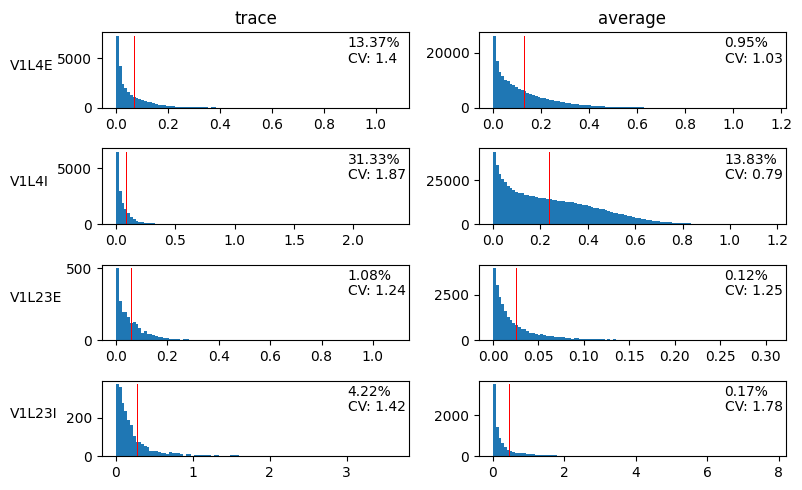

In [353]:
# Elicited activity
ds = "MNIST"
fig, axs = plt.subplots(4, 2, figsize=(8,5))
for k,v in enumerate(vars):
    evPath = "./RESULTS/variations/"+v+"/eval/on/"
    for i,p in enumerate(pops[:4]):
        a = np.loadtxt(evPath+ds+"_test100"+p).flatten()
        fLen = a.shape[0]
        a = a[a!=0]
        c,b,_ = axs[i][k].hist(a, 100)
        axs[i][k].bar(a.mean(), c.max(),width=(b[1]-b[0])*.3, color="red")
        axs[i][k].text(.8, .8, str(round(100*a.shape[0]/fLen,2))+"%", transform=axs[i][k].transAxes)
        axs[i][k].text(.8, .6, "CV: "+str(round(a.std()/a.mean(),2)), transform=axs[i][k].transAxes)
    axs[0][k].set_title(v)
for i,p in enumerate(pops[:4]): axs[i][0].text(-.3, .5, p, transform=axs[i][0].transAxes)
#fig.suptitle(ds)
fig.tight_layout()
'''
ds = "CIFAR-10"
fig, axs = plt.subplots(4, 2, figsize=(8,5))
for k,v in enumerate(vars):
    evPath = "./RESULTS/variations/"+v+"/eval/on/"
    for i,p in enumerate(pops[:4]):
        a = np.loadtxt(evPath+ds+"_test_gray100"+p).flatten()
        fLen = a.shape[0]
        a = a[a!=0]
        c,b,_ = axs[i][k].hist(a, 100)
        axs[i][k].bar(a.mean(), c.max(),width=(b[1]-b[0])*.3, color="red")
        axs[i][k].text(.8, .8, str(round(100*a.shape[0]/fLen,2))+"%", transform=axs[i][k].transAxes)
    axs[0][k].set_title(v)
for i,p in enumerate(pops[:4]): axs[i][0].text(-.3, .5, p, transform=axs[i][0].transAxes)
fig.suptitle(ds)
fig.tight_layout()

ds = "SVHN"
fig, axs = plt.subplots(4, 2, figsize=(8,5))
for k,v in enumerate(vars):
    evPath = "./RESULTS/variations/"+v+"/eval/on/"
    for i,p in enumerate(pops[:4]):
        a = np.loadtxt(evPath+ds+"_test100"+p).flatten()
        fLen = a.shape[0]
        a = a[a!=0]
        c,b,_ = axs[i][k].hist(a, 100)
        axs[i][k].bar(a.mean(), c.max(),width=(b[1]-b[0])*.3, color="red")
        axs[i][k].text(.8, .8, str(round(100*a.shape[0]/fLen,2))+"%", transform=axs[i][k].transAxes)
    axs[0][k].set_title(v)
for i,p in enumerate(pops[:4]): axs[i][0].text(-.3, .5, p, transform=axs[i][0].transAxes)
fig.suptitle(ds)
fig.tight_layout()

ds = "EMNIST"
fig, axs = plt.subplots(4, 2, figsize=(8,5))
for k,v in enumerate(vars):
    evPath = "./RESULTS/variations/"+v+"/eval/on/"
    for i,p in enumerate(pops[:4]):
        a = np.loadtxt(evPath+ds+"_test100"+p).flatten()
        fLen = a.shape[0]
        a = a[a!=0]
        c,b,_ = axs[i][k].hist(a, 100)
        axs[i][k].bar(a.mean(), c.max(),width=(b[1]-b[0])*.3, color="red")
        axs[i][k].text(.8, .8, str(round(100*a.shape[0]/fLen,2))+"%", transform=axs[i][k].transAxes)
    axs[0][k].set_title(v)
for i,p in enumerate(pops[:4]): axs[i][0].text(-.3, .5, p, transform=axs[i][0].transAxes)
fig.suptitle(ds)
fig.tight_layout()'''

## Plastic Parameters

In [ ]:
# Intrinsic plasticity
for v in vars:
    fig, axs = plt.subplots(len(pops[:-1]),2, figsize = (12,20))
    for i,p in enumerate(pops[:-1]):
        c,b,_ = axs[i][0].hist(tA[v][p], 50)
        axs[i][0].bar(tA[v][p].mean(), c.max(),width=(b[1]-b[0])*.3, color="red")
        axs[i][0].text(-.3,.5,p, transform = axs[i][0].transAxes, fontsize=14)
        c,b,_ = axs[i][1].hist(tTH[v][p], 50)
        axs[i][1].bar(tTH[v][p].mean(), c.max(),width=(b[1]-b[0])*.3, color="red")
    axs[0][0].set_title("a", fontsize=14)
    axs[0][1].set_title(r'$\theta$', fontsize=14)
    fig.tight_layout()
    fig.suptitle(v)
    fig.show()


In [ ]:
ipStats = []
for v in vars:
    meanA = []
    meanT = []
    stdA = []
    stdT = []
    for p in pops[:-1]:
        meanA.append(tA[v][p].mean())
        stdA.append(tA[v][p].std())
        meanT.append(tTH[v][p].mean())
        stdT.append(tTH[v][p].std())
    A = pd.DataFrame({"mean":meanA, "std":stdA}, index=pops[:-1])
    T = pd.DataFrame({"mean":meanT, "std":stdT}, index=pops[:-1])
    ipStats.append(pd.concat([A,T], axis=1, keys=["a","theta"]))
ipStats = pd.concat(ipStats, axis=1, keys=vars)
ipStats

In [ ]:
# Average weights
for v in vars:
    fig,axs = plt.subplots(int(len(pops)/3), 3, figsize = (20, 10))
    for i,p in enumerate(pops):
        cols = [c for c in wAvg[v].columns if p+"-" in c]
        wAvg[v][cols].plot(ax=axs[int(i/3)][i%3])
        axs[int(i/3)][i%3].set_title(p)
        axs[int(i/3)][i%3].legend(title="Target", labels=[c.split("-")[1] for c in cols])
    fig.suptitle(v)
    fig.tight_layout()
    fig.show()

In [ ]:
# Weights distributions are meh
for s in syns:
    sName = s[0]+"-"+s[1]
    wCounts = []
    wBins = []
    with open(prTrain+sName+"dist.vec") as f:
        for i, r in enumerate(f):
            if (i%2 == 0): wCounts.append(np.fromstring(r, sep=" "))
            else: wBins.append(np.fromstring(r, sep=" "))
        fig, axs = plt.subplots(4,3, figsize=(20,10))
        toshow = [0, 1, 2, 5, 10, 20, 30, 40, 50, 100, 150, 200]
        form = tk.ScalarFormatter(useMathText=True)
        form.set_scientific(True)
        form.set_powerlimits((-1,1))
        for i, t in enumerate(toshow):
            axs.flatten()[i].bar(wBins[t][:-1], wCounts[t], width=wBins[t][1]*.8, align='center')
            axs.flatten()[i].set_title(str(t*1000) + " patches")
            axs.flatten()[i].yaxis.set_major_formatter(form)
        fig.suptitle(sName)
        fig.tight_layout()
        fig.savefig(rPath+"training_sum/"+sName+"_wDists.png")
        plt.close(fig)

## Receptive Fields

In [ ]:
for v in vars[:1]:
    for s in syns[:2]:
        sName = s[0]+"-"+s[1]
        mat = np.loadtxt(rPath+v+"/training/"+sName+"weights.vec")
        mask = np.loadtxt("rateModel/architecture/matrices/"+sName)
        fE, axE = plt.subplots(10, 10, figsize = (10,10))
        fE.suptitle(sName+" On", y=.92)    
        fI, axI = plt.subplots(10, 10, figsize = (10,10))
        fI.suptitle(sName+" Off", y=.92)
        fRF, axRF = plt.subplots(10, 10, figsize = (10,10))
        fRF.suptitle(sName+" Receptive Fields", y=.92)
        for i in range(100):
            rf = mat[:,100+i][mask[:,100+i]!=0.].reshape(10,10,2)
            exc = rf[:,:,0]/rf[:,:,0].max()
            inh = rf[:,:,1]/rf[:,:,1].max()
            axE[i//10][i%10].matshow(exc, cmap=plt.cm.Blues)
            axE[i//10][i%10].set_xticks([],[])
            axE[i//10][i%10].set_yticks([],[])
            axI[i//10][i%10].matshow(inh, cmap=plt.cm.Reds)
            axI[i//10][i%10].set_xticks([],[])
            axI[i//10][i%10].set_yticks([],[])
            axRF[i//10][i%10].matshow(inh-exc, cmap=plt.cm.bwr)
            axRF[i//10][i%10].set_xticks([],[])
            axRF[i//10][i%10].set_yticks([],[])

In [291]:
from scipy.optimize import curve_fit as cf
import math as m
import random as r
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings('ignore')

In [308]:

def gab(c, sx, sy, f, th, phi, A, B):
    x = c%10
    y = np.floor(c/10)
    x1 = x*np.cos(th)+y*np.sin(th)
    y1 = -x*np.sin(th)+y*np.cos(th)
    xp = -(x1**2/(2*sx**2))-(y1**2/(2*sy**2))
    return A*np.exp(xp)*np.cos(2*m.pi*f*x1-phi)+B

def find_ext(x, y):
    try:
        p,_,inf,_,_ = cf(gab,x,y, p0=[r.uniform(0,10),r.uniform(0,10), r.uniform(0,100), 6.28*r.random(), 6.28*r.random(), r.uniform(0,5), r.random()], full_output=True)
        err = mae(y, inf["fvec"])
        return p[0], p[1], p[3], err
    except RuntimeError:
        return 0,0,0,-1

for v in vars:
    for s in syns[:2]:
        sName = s[0]+"-"+s[1]
        print("Calculating extents for: "+v+" - "+sName)
        mat = np.loadtxt(rPath+v+"/training/"+sName+"weights.vec")
        mask = np.loadtxt("rateModel/architecture/matrices/"+sName)
        pars = {"sx":[], "sy":[], "th":[], "err":[]}
        noRf = mat.shape[1]
        for i in range(noRf):
            if i%100==0: print("  "+str(i)+"/"+str(noRf))
            rf = mat[:,i][mask[:,i]!=0.].reshape(10,10,2)
            exc = rf[:,:,0]/rf[:,:,0].max()
            inh = rf[:,:,1]/rf[:,:,1].max()
            rf = inh-exc
            x = [i for i in range(100)]
            y = rf.flatten()
            sx, sy, th = 0,0,0
            err = 1000000000
            for _ in range(100):
                nErr = -1
                noTries = 0
                while nErr == -1 or noTries==10:
                    Tsx, Tsy, Tth, nErr = find_ext(x, y)
                    noTries+=1
                if nErr < err and abs(Tsx) <=10 and abs(Tsy)<=10:
                    err = nErr
                    sx = Tsx
                    sy = Tsy
                    th = Tth
            pars["sx"].append(sx)
            pars["sy"].append(sy)
            pars["th"].append(th)
            pars["err"].append(err)
        pd.DataFrame(pars).to_csv(rPath+v+"/training/"+sName+"extents.csv", index=False)

Calculating extents for: trace - LGN-V1L4E
  0/2116
  100/2116
  200/2116
  300/2116
  400/2116
  500/2116
  600/2116
  700/2116
  800/2116
  900/2116
  1000/2116
  1100/2116
  1200/2116
  1300/2116
  1400/2116
  1500/2116
  1600/2116
  1700/2116
  1800/2116
  1900/2116
  2000/2116
  2100/2116
Calculating extents for: trace - LGN-V1L4I
  0/529
  100/529
  200/529
  300/529
  400/529
  500/529
Calculating extents for: average - LGN-V1L4E
  0/2116
  100/2116
  200/2116
  300/2116
  400/2116
  500/2116
  600/2116
  700/2116
  800/2116
  900/2116
  1000/2116
  1100/2116
  1200/2116
  1300/2116
  1400/2116
  1500/2116
  1600/2116
  1700/2116
  1800/2116
  1900/2116
  2000/2116
  2100/2116
Calculating extents for: average - LGN-V1L4I
  0/529
  100/529
  200/529
  300/529
  400/529
  500/529


In [309]:
for v in vars:
    for s in syns[:2][:-1]:
        sName = s[0]+"-"+s[1]
        tar = s[1]
        p = pd.read_csv(rPath+v+"/training/"+sName+"extents.csv")
p

,sx,sy,th,err
0,3.786938,2.822429,2.930276,0.262701
1,2.985292,-3.532847,3.742179,0.170426
2,0.308561,0.005880,2.364929,0.489946
3,-3.848176,-2.856650,5.971903,0.259600
4,2.148029,-7.057911,0.664397,0.237037
...,...,...,...,...
2111,-0.200080,-4.941762,6.164421,0.486014
2112,4.201435,-0.321069,0.046940,0.290341
2113,-3.721581,-0.046047,3.271208,0.289075
2114,1.518297,7.359171,0.031308,0.348951


In [5]:
from struct import unpack as unp
no = 20
with open("./RESULTS/popAvg/It0", mode="rb") as f:
    cont = f.read(4*no)
    c1 = unp("f"*no, cont)
print(c1)

(0.00612410344183445, -0.017241328954696655, -0.0023230910301208496, -0.013438485562801361, 0.0412459634244442, 0.030878135934472084, 0.04598921537399292, 0.04134783148765564, 0.03207331523299217, 0.030559761449694633, 0.03133472055196762, 0.0375639870762825, 0.00345744751393795, 0.028263062238693237, 0.031193995848298073, 0.03401238098740578, 0.035069726407527924, 0.019050143659114838, 0.012274193577468395, 0.035794492810964584)


In [7]:
with open("./RESULTS/popAvg/WIt0", mode="r") as f:
    cont = f.readline()

print(cont)

0.999389 1.00122 0.992159 0.99781 0.978609 0.98464 0.978944 0.980594 0.982057 0.989767 0.992185 0.994873 1.00086 0.973874 0.99551 0.985373 0.986305 0.991793 0.999305 0.994012 0.992661 0.993504 0.993426 0.997516 1.00035 1.0017 1.00005 1.00238 0.996587 0.998686 0.985296 0.971766 0.981713 1.00062 0.991639 0.993802 0.986148 0.991479 0.991346 0.976487 1.00295 1.00525 0.975908 0.993558 0.980048 0.991378 0.997648 1.00069 0.990888 1.0015 0.986158 1.00029 0.997734 0.982643 1.0017 1.00075 0.982037 0.99565 0.995557 1.00256 0.998334 1.0008 1.00028 0.991651 1.00672 1.00107 0.976466 1.00332 1.00102 0.97982 0.999967 0.991145 0.97183 0.997191 1.00137 0.989265 0.987312 0.991914 0.988347 1.00593 0.992387 1.00246 0.99916 0.995882 0.992061 0.989078 0.992538 0.98376 1.00004 0.996625 0.995921 0.99339 0.980374 0.998676 0.983738 1.0024 0.994424 0.993127 0.993744 0.998999 0.981568 0.983837 0.997633 1.00038 0.990247 0.992264 0.968161 0.996148 0.999127 0.999432 0.998234 0.997427 0.994691 0.996401 0.995917 0.9988